# **Feedback Analyzer**

**Before running the program upload the reviews.csv file to**
https://drive.google.com/file/d/1AmZ2dDsyr62vGyW4oqWYvGx5JtugDT3L/view?usp=sharing

In [ ]:
!pip install nltk
!pip install textblob

In [18]:
import csv
import pandas as pd
import numpy as np
from textblob import TextBlob
import string
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
def preprocess_review(func):
    def wrapper(*args, **kwargs):
        review_content = args[1]
        # Convert to lowercase and remove punctuation
        review_content = review_content.lower().translate(str.maketrans('', '', string.punctuation))
        # Pass the modified review_content back to the function
        return func(args[0], review_content, **kwargs)
    return wrapper


In [20]:
# Customer Class
class Customer:
    def __init__(self, customer_id, name):
        self.customer_id = customer_id
        self.name = name
        self.reviews = []

    def add_review(self, review):
        self.reviews.append(review)

In [21]:
# Review Class
class Review:
    def __init__(self, product_id, date, content, rating):
        if not content:
            raise ValueError("Review content cannot be empty.")
        if not (1 <= rating <= 5):
            raise ValueError("Rating must be between 1 and 5.")

        self.product_id = product_id
        self.date = date
        self.content = content
        self.rating = rating
        self.sentiment_score = None

In [22]:
class SentimentAnalyzer:
    @preprocess_review
    def analyze(self, review_content):
        sid = SentimentIntensityAnalyzer()  # Make sure to import SentimentIntensityAnalyzer
        sentiment_scores = sid.polarity_scores(review_content)
        return sentiment_scores['compound']


In [23]:
def save_to_file(customers, filename='reviews.csv'):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Customer ID', 'Product ID', 'Review', 'Date', 'Rating'])
        for customer in customers:
            for review in customer.reviews:
                writer.writerow([customer.customer_id, review.product_id, review.content, review.date, review.rating])

def load_from_file(filename='reviews.csv'):
    customers = {}
    with open(filename, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            customer_id = row['Customer ID']
            name = row.get('Name', f"Customer_{customer_id}")

            if customer_id not in customers:
                customers[customer_id] = Customer(customer_id, name)

            review = Review(row['Product ID'], row['Date'], row['Review'], int(row['Rating']))
            customers[customer_id].reviews.append(review)
    return list(customers.values())


In [24]:
def analyze_data(filename='reviews.csv'):
    df = pd.read_csv(filename)

    # Overall customer satisfaction (average sentiment)
    df['Sentiment Score'] = df['Review'].apply(lambda review: TextBlob(review).sentiment.polarity)
    overall_satisfaction = df['Sentiment Score'].mean()

    # Product ratings based on customer feedback
    product_ratings = df.groupby('Product ID')['Rating'].mean()

    # Products with the most positive and negative reviews
    most_positive_product = product_ratings.idxmax()
    most_negative_product = product_ratings.idxmin()

    return overall_satisfaction, product_ratings, most_positive_product, most_negative_product


In [25]:
def numpy_calculations(dataframe):
    # Convert ratings to NumPy array
    ratings = dataframe['Rating'].to_numpy()

    # Calculate average ratings for each product
    avg_ratings_by_product = dataframe.groupby('Product ID')['Rating'].mean().to_numpy()

    # Calculate mean, median, and mode for all ratings
    mean_rating = np.mean(ratings)
    median_rating = np.median(ratings)
    mode_rating = Counter(ratings).most_common(1)[0][0]  # Use Counter for mode

    # Calculate sentiment score statistics
    sentiment_scores = dataframe['Sentiment Score'].to_numpy()
    mean_sentiment = np.mean(sentiment_scores)
    median_sentiment = np.median(sentiment_scores)
    mode_sentiment = Counter(sentiment_scores).most_common(1)[0][0]

    return {
        'mean_rating': mean_rating,
        'median_rating': median_rating,
        'mode_rating': mode_rating,
        'avg_ratings_by_product': avg_ratings_by_product,
        'mean_sentiment': mean_sentiment,
        'median_sentiment': median_sentiment,
        'mode_sentiment': mode_sentiment
    }


In [31]:
def create_dataframe(customers, analyzer):
    # Create a DataFrame from customer reviews
    data = [
        {
            'Customer ID': customer.customer_id,
            'Product ID': review.product_id,
            'Review': review.content,
            'Date': review.date,
            'Rating': review.rating,
            'Sentiment Score': analyzer.analyze(review.content)
        }
        for customer in customers
        for review in customer.reviews
    ]
    return pd.DataFrame(data)

In [32]:
def main():
    customers = load_from_file('reviews.csv')
    analyzer = SentimentAnalyzer()

    df = create_dataframe(customers, analyzer)

    overall_satisfaction, product_ratings, most_positive_product, most_negative_product = analyze_data()
    stats = numpy_calculations(df)

    print(f"Overall customer satisfaction (average sentiment score): {overall_satisfaction:.2f}")
    print(f"Average product ratings:\n{product_ratings}")
    print(f"Most positive product: {most_positive_product}")
    print(f"Most negative product: {most_negative_product}")
    print(f"Statistical summary:\nMean Rating: {stats['mean_rating']}\nMedian Rating: {stats['median_rating']}\nMode Rating: {stats['mode_rating']}")

    save_to_file(customers)

In [33]:
if __name__ == "__main__":
    main()

Overall customer satisfaction (average sentiment score): 0.03
Average product ratings:
Product ID
P001    3.285714
P002    2.642857
P003    3.107692
P004    1.153846
P005    1.461538
Name: Rating, dtype: float64
Most positive product: P001
Most negative product: P004
Statistical summary:
Mean Rating: 2.582089552238806
Median Rating: 2.0
Mode Rating: 1


# **Testing and Error Handling**

In [11]:
import unittest
from textblob import TextBlob

class TestReviewSystem(unittest.TestCase):

    def setUp(self):
        self.customer = Customer('C001', 'John Doe')
        self.review = Review('P001', '2024-09-01', 'Great product!', 5)
        self.customer.add_review(self.review)
        self.analyzer = SentimentAnalyzer()

    def test_add_review(self):
        self.assertEqual(len(self.customer.reviews), 1)
        self.assertEqual(self.customer.reviews[0].content, 'Great product!')

    def test_sentiment_analysis(self):
        sentiment = self.analyzer.analyze('This is amazing!')
        self.assertGreater(sentiment, 0)  # Positive sentiment should be greater than 0

    def test_empty_review(self):
        with self.assertRaises(ValueError):
            Review('P001', '2024-09-01', '', 5)

    def test_invalid_rating(self):
        with self.assertRaises(ValueError):
            Review('P001', '2024-09-01', 'Average product', 7)  # Invalid rating

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


....
----------------------------------------------------------------------
Ran 4 tests in 0.015s

OK


# **Sentiment Score vs Rating (Scatter Plot)**

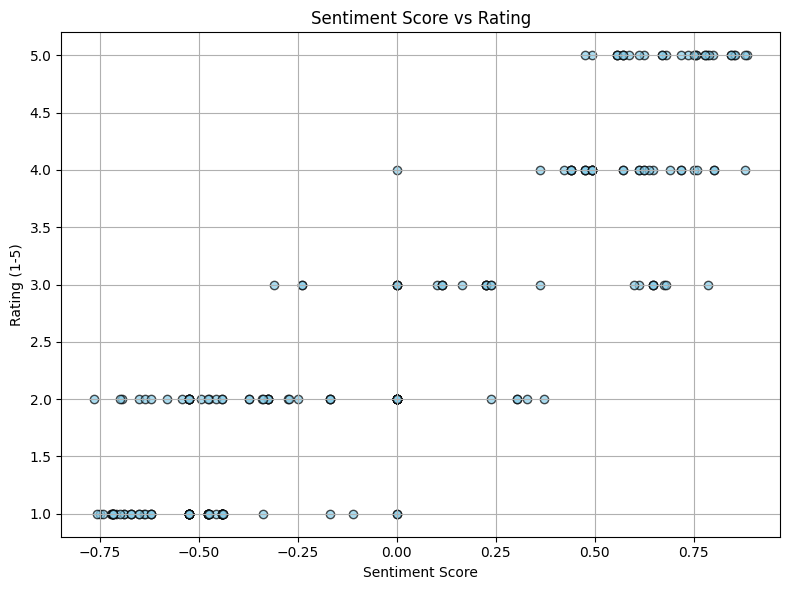

In [34]:
customers = load_from_file('reviews.csv')
analyzer = SentimentAnalyzer()

df = create_dataframe(customers, analyzer)

plt.figure(figsize=(8, 6))  # Adjust the figure size
plt.scatter(df['Sentiment Score'], df['Rating'], color='skyblue', edgecolors='black', alpha=0.7)
plt.xlabel('Sentiment Score')
plt.ylabel('Rating (1-5)')
plt.title('Sentiment Score vs Rating')
plt.grid(True)

# Show the plot with layout adjustments
plt.tight_layout()
plt.show()

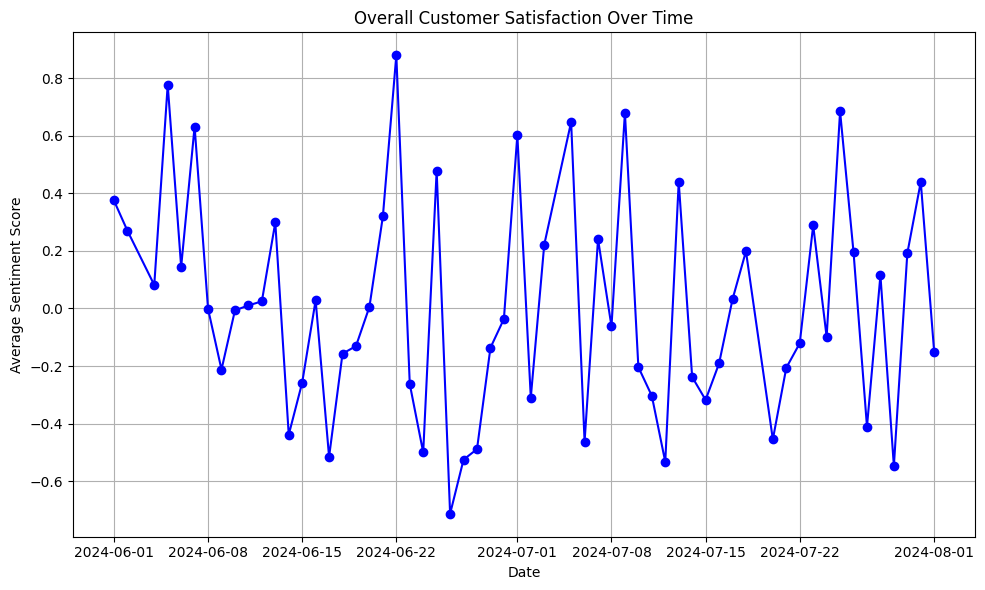

In [35]:
df['Date'] = pd.to_datetime(df['Date'])  # Convert Date to datetime
sentiment_over_time = df.groupby('Date')['Sentiment Score'].mean()

plt.figure(figsize=(10, 6))
plt.plot(sentiment_over_time.index, sentiment_over_time.values, marker='o', color='blue')
plt.title('Overall Customer Satisfaction Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

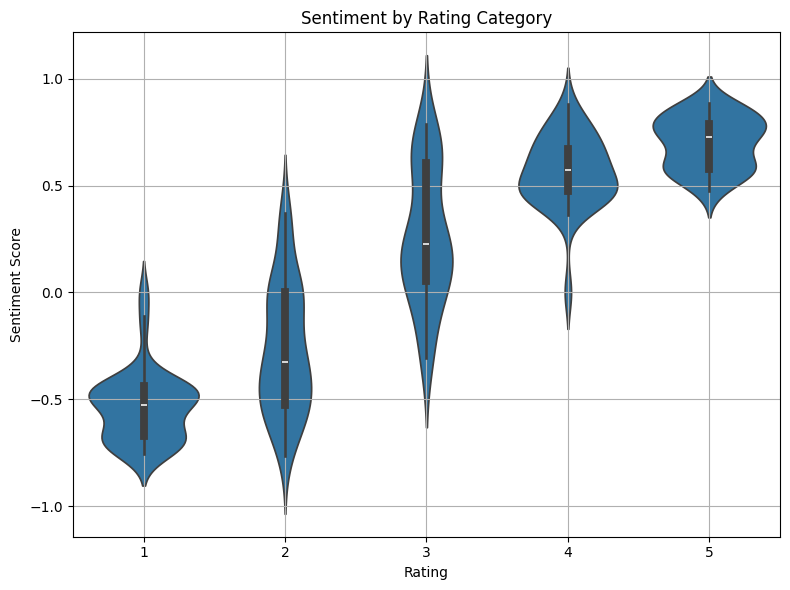

In [37]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.violinplot(x='Rating', y='Sentiment Score', data=df)
plt.title('Sentiment by Rating Category')
plt.xlabel('Rating')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

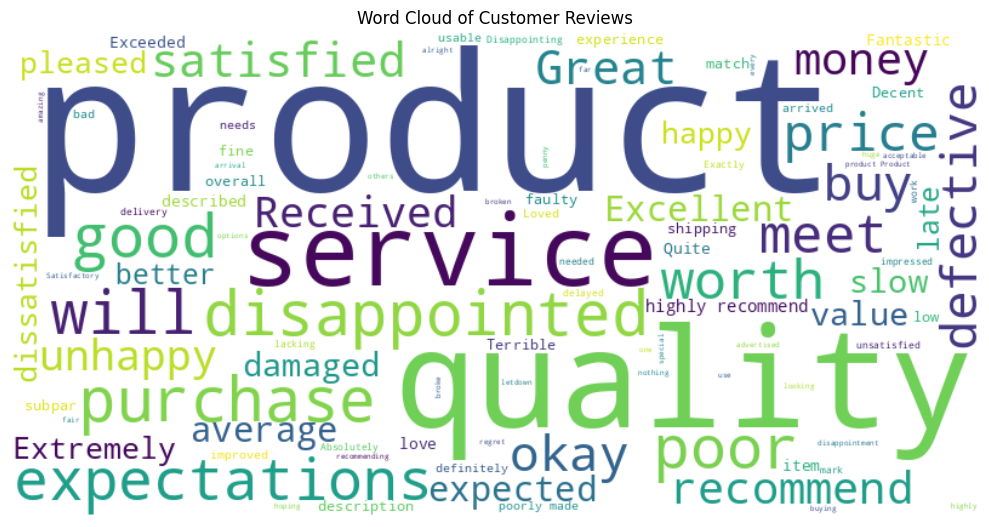

In [38]:
from wordcloud import WordCloud

all_reviews = ' '.join(df['Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Customer Reviews')
plt.tight_layout()
plt.show()

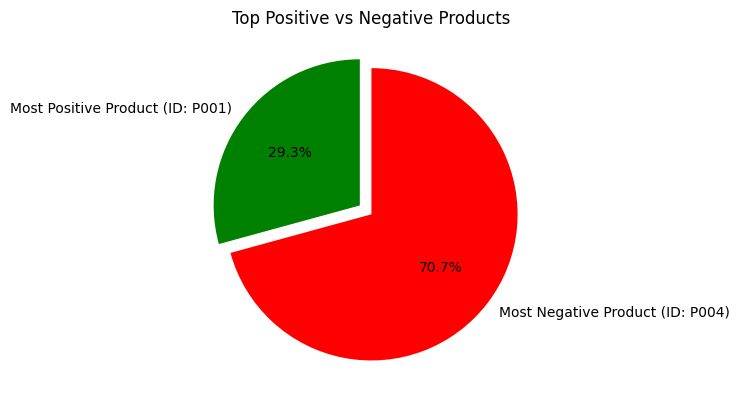

In [44]:
product_ratings = df.groupby('Product ID')['Sentiment Score'].mean()

most_positive_product = product_ratings.idxmax()
most_negative_product = product_ratings.idxmin()

# Ensure non-negative sizes by taking absolute values of sentiment scores
sizes = [abs(product_ratings.loc[most_positive_product]), abs(product_ratings.loc[most_negative_product])]
labels = [f'Most Positive Product (ID: {most_positive_product})', f'Most Negative Product (ID: {most_negative_product})']
colors = ['green', 'red']

explode = [0.1, 0]  # Only the first slice (most positive) will be "exploded"

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=90)
plt.title('Top Positive vs Negative Products')
plt.tight_layout()
plt.show()